# Predicting Fantasy Football Premier League Points

Fantasy Football Premier League (_FPL_) is an online game, where each player 'manages' a virtual team.

Each manager must select a team consisting of 15 premier league players: 11 starters and 4 substitutes.


## The basics:

* Each premier league player gains points based on their real-life footballing performances for each match
* *For example, points are earned for goals, assists and clean sheets, and lost for yellow/red cards*
* The 4 positions: *goalkeepers, defenders, midfielders, *and *strikers* all earn points differently based on those metrics
* Before the start of each gameweek (set of matches), every manager selects their team
* The manager with the most points at the end of the season wins

We wish to predict a given premier league player's points for a given gameweek (match) using machine learning methods.

## The data

Each observation represents a player's statistical performance for a given match, using metrics such as `goals`, `assists`, `clean_sheets`.

The data has 4 types of feature variables:
* **Identifiers**
    * Variables that help identify the observation.
    * For example: `player_name`, `team_name`, and `date` - the date of the match
* **Outcome metrics**
    * These variables are metrics that are readily available to view at the end of a match
    * For example: `goals`, `assists`, `yellow_cards`, etc
* **FPL metrics**
    * Variables calculated by the FPL game-engine, essentially, to assess a players performance
    * These variables are a bit more abstract, and we don't know how these values are calculated
    * For example, `influence`, `creativity`, and `threat`
* **Underlying metrics**
    * "_Hidden_" variables which are not so readily available
    * More work has to be done to calculate these values
    * We know how they are calculated
    * For example:
        * `xG_player`, the expected goals a player should've scored
        * `xA`, the expected assists a player should've provided
        * `ppda_att`, the passes per defensive action of the attacking team

In [18]:
import pandas as pd

data = pd.read_csv('premier_league_data_21_22.csv')

identifiers = ['element_type', 'date', 'player_name', 'team_name', 'opponent_team_name', 'event', 'h_a']

outcome_metrics = ['goals_scored','assists', 'clean_sheets','goals_conceded', 'own_goals', 'team_scored', 'team_conceded', 'yellow_cards','red_cards','penalties_missed','penalties_saved', 'saves','npg', 'wins', 'draws','loses', 'shots','minutes']

fpl_metrics = ['ict_index', 'influence', 'creativity', 'bonus', 'threat','total_points']

underlying_metrics = ['xG_player','xA', 'xG_team','npxG_team','xGA','npxGA','key_passes', 'xGChain', 'xGBuildup', 'npxGD', 'deep', 'deep_allowed', 'ppda_allowed_att', 'ppda_allowed_def', 'ppda_att', 'ppda_def']

df = data[
    identifiers + outcome_metrics + fpl_metrics + underlying_metrics
    ]

df

,element_type,date,player_name,team_name,opponent_team_name,event,h_a,goals_scored,assists,clean_sheets,...,key_passes,xGChain,xGBuildup,npxGD,deep,deep_allowed,ppda_allowed_att,ppda_allowed_def,ppda_att,ppda_def
0,1,2021-08-13,Bernd Leno,Arsenal,Brentford,1.0,a,0,0,0,...,0,0.097028,0.097028,-0.864330,10.0,7.0,290,18,127,22
1,1,2021-08-22,Bernd Leno,Arsenal,Chelsea,2.0,h,0,0,0,...,0,0.000000,0.000000,-3.011221,3.0,19.0,156,15,376,23
2,1,2021-08-28,Bernd Leno,Arsenal,Manchester City,3.0,a,0,0,0,...,0,0.000000,0.000000,-4.355925,0.0,14.0,91,18,365,7
3,1,2022-03-19,Bernd Leno,Arsenal,Aston Villa,30.0,a,0,0,1,...,0,0.092356,0.092356,0.835845,11.0,3.0,302,14,246,18
4,4,2021-08-22,Pierre-Emerick Aubameyang,Arsenal,Chelsea,2.0,h,0,0,0,...,0,0.039828,0.000000,-3.011221,3.0,19.0,156,15,376,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10450,3,2022-03-18,Chiquinho,Wolverhampton Wanderers,Leeds,30.0,h,0,0,0,...,0,0.059847,0.059847,-1.580280,8.0,6.0,251,30,272,20
10451,3,2022-04-02,Chiquinho,Wolverhampton Wanderers,Aston Villa,31.0,h,0,0,0,...,0,0.000000,0.000000,0.470120,4.0,8.0,266,22,268,22
10452,3,2022-05-07,Chiquinho,Wolverhampton Wanderers,Chelsea,36.0,a,0,2,0,...,2,0.541080,0.000000,0.624390,3.0,10.0,212,22,293,16
10453,3,2022-05-11,Chiquinho,Wolverhampton Wanderers,Manchester City,36.0,h,0,0,0,...,0,0.119138,0.047840,-2.981183,6.0,13.0,259,28,543,15


In [30]:
df.describe()

,element_type,event,goals_scored,assists,clean_sheets,goals_conceded,own_goals,team_scored,team_conceded,yellow_cards,...,key_passes,xGChain,xGBuildup,npxGD,deep,deep_allowed,ppda_allowed_att,ppda_allowed_def,ppda_att,ppda_def
count,10455.000000,10455.000000,10455.000000,10455.000000,10455.000000,10455.000000,10455.000000,10455.000000,10455.000000,10455.000000,...,10455.000000,10455.000000,10455.000000,10455.000000,10455.000000,10455.000000,10455.000000,10455.000000,10455.000000,10455.000000
mean,2.646963,20.127212,0.098996,0.088379,0.229938,1.124821,0.003252,1.410234,1.414538,0.123673,...,0.680344,0.293672,0.177772,-0.006101,6.904065,6.946246,242.585270,20.702056,243.323290,20.669440
std,0.801755,11.300066,0.334048,0.310880,0.420813,1.213253,0.056937,1.296546,1.297501,0.329224,...,1.040398,0.386652,0.281226,1.415429,4.342748,4.360125,86.322862,6.725471,86.434196,6.745841
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-4.355925,0.000000,0.000000,71.000000,4.000000,71.000000,4.000000
25%,2.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.028049,0.000000,-0.865230,4.000000,4.000000,175.000000,16.000000,175.000000,16.000000
50%,3.000000,21.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.134997,0.063075,-0.003850,6.000000,6.000000,238.000000,20.000000,239.000000,20.000000
75%,3.000000,30.000000,0.000000,0.000000,0.000000,2.000000,0.000000,2.000000,2.000000,0.000000,...,1.000000,0.429734,0.214384,0.864105,9.000000,9.000000,302.000000,25.000000,303.000000,25.000000
max,4.000000,38.000000,4.000000,4.000000,1.000000,7.000000,1.000000,7.000000,7.000000,1.000000,...,10.000000,3.396751,2.629082,4.355925,27.000000,27.000000,571.000000,42.000000,571.000000,42.000000


## The predictor variable
* The predictor in our data is `total_points`.
* This is the number of FPL points a player got in that game, for actions such as scoring or assisting a goal, or not conceding a goal.
* Players in different positions score points differently, i.e. defenders earn points for not conceding goals, whereas strikers do not.
* The position of a player is given by `element_type`.

* This means `total_points` is a linear combination of a selection of the other feature variables.

* The scoring system is broken down in further detail [here](https://www.premierleague.com/news/2174909).

The dataframe below shows the points for each player in each game using only identifier variables:

In [19]:
df[identifiers + ['total_points']]

,element_type,date,player_name,team_name,opponent_team_name,event,h_a,total_points
0,1,2021-08-13,Bernd Leno,Arsenal,Brentford,1.0,a,1
1,1,2021-08-22,Bernd Leno,Arsenal,Chelsea,2.0,h,2
2,1,2021-08-28,Bernd Leno,Arsenal,Manchester City,3.0,a,1
3,1,2022-03-19,Bernd Leno,Arsenal,Aston Villa,30.0,a,6
4,4,2021-08-22,Pierre-Emerick Aubameyang,Arsenal,Chelsea,2.0,h,1
...,...,...,...,...,...,...,...,...
10450,3,2022-03-18,Chiquinho,Wolverhampton Wanderers,Leeds,30.0,h,1
10451,3,2022-04-02,Chiquinho,Wolverhampton Wanderers,Aston Villa,31.0,h,1
10452,3,2022-05-07,Chiquinho,Wolverhampton Wanderers,Chelsea,36.0,a,9
10453,3,2022-05-11,Chiquinho,Wolverhampton Wanderers,Manchester City,36.0,h,2


I am aiming to predict the `total_points` for a given player in a given match, using only past data, as we won't know a player's stats for a match before that match has occurred!
* i.e. for each given game, look at a player's previous x games and try and predict the points

How can we do this?
* Time-series modelling could be used for each player
    * This can't be universally applied as a model for all future players, only for that particular player

* Thus we can use past observations as feature variables due to the nature of the data, however we must explore the optimal number of games to use for our predictions
* Then we can apply linear models, tree models and neural networks to see which model suits our data best.

## Benchmark Model

As a benchmark model, I looked at averaging each player's past points, and using this average as an estimate for the current ones.

As an example, look at Cristiano Ronaldo's point data for each match. By averaging past points, we could predict points for any given game.

In [20]:
df[df['player_name']=='Cristiano Ronaldo'][['player_name','date','opponent_team_name','total_points']]

,player_name,date,opponent_team_name,total_points
6710,Cristiano Ronaldo,2021-09-11,Newcastle United,13
6711,Cristiano Ronaldo,2021-09-19,West Ham,6
6712,Cristiano Ronaldo,2021-09-25,Aston Villa,2
6713,Cristiano Ronaldo,2021-10-02,Everton,1
6714,Cristiano Ronaldo,2021-10-16,Leicester,2
6715,Cristiano Ronaldo,2021-10-24,Liverpool,1
6716,Cristiano Ronaldo,2021-10-30,Tottenham,12
6717,Cristiano Ronaldo,2021-11-06,Manchester City,1
6718,Cristiano Ronaldo,2021-11-20,Watford,5
6719,Cristiano Ronaldo,2021-11-28,Chelsea,0


Below, I found the **SSR**, **SSE**, **SST** and **$R^{2}$** for the benchmark model, and plotted how they vary as the number of games we choose to average points for - the rolling window - changes.

In [21]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

def rolling_benchmark_model(df, x):
    df.index.rename('entry', inplace=True)

    rolling_pts = df.groupby('player_name')['total_points'].rolling(x).mean().groupby('player_name').shift(1)
    rolling_pts.rename('rolling_total_points', inplace=True)

    indexed_df = df.reset_index().set_index(['player_name', 'entry'])
    benchmark_df = pd.merge(rolling_pts, indexed_df, how='inner', left_index=True, right_index=True).dropna()

    # Calculate SSE, SSR, SST, RSQ for model of rolling size window: x
    sse = sum((benchmark_df['total_points'] - benchmark_df['rolling_total_points']) ** 2)
    ssr = sum((benchmark_df['rolling_total_points'] - benchmark_df['total_points'].mean()) ** 2)
    sst = sse + ssr
    rsq = ssr / sst

    stderr = np.sqrt(sse / (len(benchmark_df) - 2))

    return sse, ssr, sst, rsq, stderr, benchmark_df


In [22]:
temp = [rolling_benchmark_model(df, i) for i in range(1, 30)]
rol_window_std_errs = [i[4] for i in temp]
rol_window_sse = [i[0] for i in temp]
rol_window_ssr = [i[1] for i in temp]
rol_window_sst = [i[2] for i in temp]
rol_window_rsq = [i[3] for i in temp]

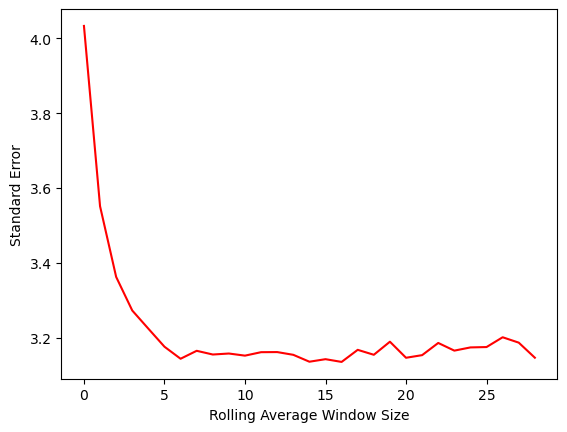

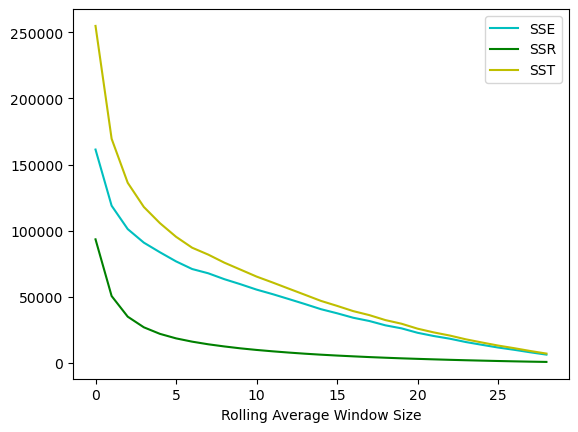

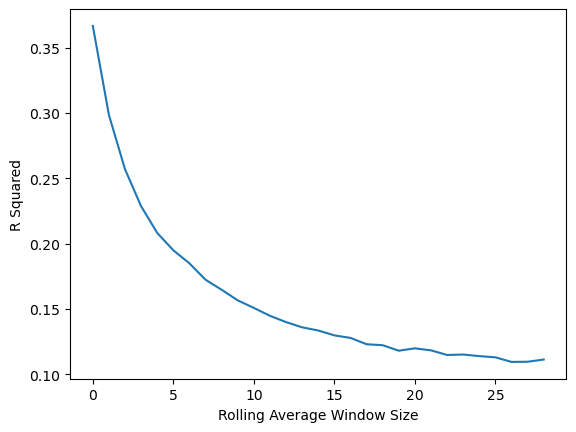

In [23]:
plt.figure(1)
plt.ylabel('Standard Error')
plt.xlabel('Rolling Average Window Size')
plt.plot(rol_window_std_errs, 'r')

plt.figure(2)

# plt.subplot(311)
# plt.ylabel('SSE')
plt.plot(rol_window_sse, 'c', label='SSE')

# plt.subplot(312)
# plt.ylabel('SSR')
plt.plot(rol_window_ssr, 'g', label='SSR')

# plt.subplot(313)
# plt.ylabel('SST')
plt.xlabel('Rolling Average Window Size')
plt.plot(rol_window_sst, 'y', label='SST')

plt.legend()

plt.figure(3)
plt.ylabel('R Squared')
plt.xlabel('Rolling Average Window Size')
plt.plot(rol_window_rsq)

In [24]:
# pd.merge(df,df.groupby('player_name')[outcome_metrics].shift(1).add_suffix('_last_game'),left_index=True,right_index=True,how='inner')